In [15]:
import pandas as pd
import numpy as np
from sklearn import metrics, model_selection, linear_model
from matplotlib import pyplot as plt
import lightgbm as lgb


/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [4]:
file_path = '/Users/JQC/Desktop/资料/第五课资料/Acard.txt'
data = pd.read_csv(file_path)
data.head()

,obs_mth,bad_ind,uid,td_score,jxl_score,mj_score,rh_score,zzc_score,zcx_score,person_info,finance_info,credit_info,act_info
0,2018-10-31,0.0,A10000005,0.675349,0.144072,0.186899,0.483640,0.928328,0.369644,-0.322581,0.023810,0.00,0.217949
1,2018-07-31,0.0,A1000002,0.825269,0.398688,0.139396,0.843725,0.605194,0.406122,-0.128677,0.023810,0.00,0.423077
2,2018-09-30,0.0,A1000011,0.315406,0.629745,0.535854,0.197392,0.614416,0.320731,0.062660,0.023810,0.10,0.448718
3,2018-07-31,0.0,A10000481,0.002386,0.609360,0.366081,0.342243,0.870006,0.288692,0.078853,0.071429,0.05,0.179487
4,2018-07-31,0.0,A1000069,0.406310,0.405352,0.783015,0.563953,0.715454,0.512554,-0.261014,0.023810,0.00,0.423077


In [5]:
# 查看月份分布
data.obs_mth.unique()

array(['2018-10-31', '2018-07-31', '2018-09-30', '2018-06-30',
       '2018-11-30'], dtype=object)

In [6]:
train = data[data.obs_mth != '2018-11-30'].reset_index().copy()
val = data[data.obs_mth == '2018-11-30'].reset_index().copy()

In [7]:
train.head()

,index,obs_mth,bad_ind,uid,td_score,jxl_score,mj_score,rh_score,zzc_score,zcx_score,person_info,finance_info,credit_info,act_info
0,0,2018-10-31,0.0,A10000005,0.675349,0.144072,0.186899,0.483640,0.928328,0.369644,-0.322581,0.023810,0.00,0.217949
1,1,2018-07-31,0.0,A1000002,0.825269,0.398688,0.139396,0.843725,0.605194,0.406122,-0.128677,0.023810,0.00,0.423077
2,2,2018-09-30,0.0,A1000011,0.315406,0.629745,0.535854,0.197392,0.614416,0.320731,0.062660,0.023810,0.10,0.448718
3,3,2018-07-31,0.0,A10000481,0.002386,0.609360,0.366081,0.342243,0.870006,0.288692,0.078853,0.071429,0.05,0.179487
4,4,2018-07-31,0.0,A1000069,0.406310,0.405352,0.783015,0.563953,0.715454,0.512554,-0.261014,0.023810,0.00,0.423077


In [8]:
#这是我们全部的变量，info结尾的是自己做的无监督系统输出的个人表现，score结尾的是收费的外部征信数据
feature_lst = ['person_info','finance_info','credit_info','act_info','td_score','jxl_score','mj_score','rh_score']

In [10]:
x = train[feature_lst]
y = train['bad_ind']

val_x = val[feature_lst]
val_y = val['bad_ind']
lr_model = linear_model.LogisticRegression(C=0.1)
lr_model.fit(x, y)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

train_ks :  0.4144413866157737
val_ks :  0.3709405449809594


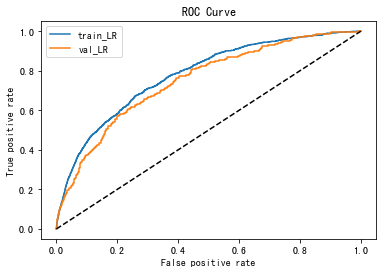

In [14]:
y_pred = lr_model.predict_proba(x)[:, 1]
fpr_train, tpr_train, thresholds = metrics.roc_curve(y, y_pred)
train_ks = abs(fpr_train - tpr_train).max()
print('train_ks : ',train_ks)


y_val_pred = lr_model.predict_proba(val_x)[:, 1]
fpr_val, tpr_val, thresholds = metrics.roc_curve(val_y, y_val_pred)
val_ks = abs(fpr_val - tpr_val).max()
print('val_ks : ',val_ks)

plt.plot(fpr_train, tpr_train, label='train_LR')
plt.plot(fpr_val, tpr_val, label='val_LR')
plt.plot([0,1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc = 'best')
plt.show()

In [18]:
train_x,test_x,train_y,test_y = model_selection.train_test_split(x,y,random_state=0,test_size=0.2)

def lgb_test(train_x,train_y,test_x,test_y):
    model = lgb.LGBMClassifier(boosting_type='gbdt',
                               objective='binary',
                               metric='auc',
                               learning_rate=0.1,
                               n_estimators = 24,
                               max_depth=5,
                               num_leaves=20,
                               max_bin = 45,
                               min_data_in_leaf = 6,
                               bagging_fraction = 0.6,
                               bagging_freq = 0,
                               feature_fraction = 0.8,
                              )
    
    model.fit(train_x,train_y,eval_set = [(train_x,train_y),(test_x,test_y)],eval_metric = 'auc')
    return model,model.best_score_['valid_1']['auc'],


lgb_model , lgb_auc  = lgb_test(train_x,train_y,test_x,test_y)
feature_importance = pd.DataFrame({'name':lgb_model.booster_.feature_name(),
                                   'importance':lgb_model.feature_importances_})\
                                    .sort_values(by=['importance'],ascending=False)

feature_importance


[1]	training's auc: 0.759467	valid_1's auc: 0.753322
[2]	training's auc: 0.809023	valid_1's auc: 0.805658
[3]	training's auc: 0.809328	valid_1's auc: 0.803858
[4]	training's auc: 0.810298	valid_1's auc: 0.801355
[5]	training's auc: 0.814873	valid_1's auc: 0.807356
[6]	training's auc: 0.816492	valid_1's auc: 0.809279
[7]	training's auc: 0.820213	valid_1's auc: 0.809208
[8]	training's auc: 0.823931	valid_1's auc: 0.812081
[9]	training's auc: 0.82696	valid_1's auc: 0.81453
[10]	training's auc: 0.827882	valid_1's auc: 0.813428
[11]	training's auc: 0.828881	valid_1's auc: 0.814226
[12]	training's auc: 0.829577	valid_1's auc: 0.813749
[13]	training's auc: 0.830406	valid_1's auc: 0.813156
[14]	training's auc: 0.830843	valid_1's auc: 0.812973
[15]	training's auc: 0.831587	valid_1's auc: 0.813501
[16]	training's auc: 0.831898	valid_1's auc: 0.813611
[17]	training's auc: 0.833751	valid_1's auc: 0.81393
[18]	training's auc: 0.834139	valid_1's auc: 0.814532
[19]	training's auc: 0.835177	valid_1's 

,name,importance
2,credit_info,98
3,act_info,62
4,td_score,54
5,jxl_score,50
7,rh_score,50
0,person_info,49
1,finance_info,47
6,mj_score,46
